
## TD forecast on python

In [2]:
%load_ext autoreload
%autoreload 2
import pyodbc
import pandas as pd

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression


server = '10.16.157.42'
database = 'RB_DATA'

connection_string = 'DRIVER={ODBC Driver 17 for SQL Server};SERVER=' + server + ';DATABASE=' + database + ';Trusted_Connection=yes'
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()
sql_query = '''
SELECT * FROM USER_DATA.HIENNPD3.FCST_EOP_TD_MAINMODEL 
'''
cursor.execute(sql_query)
rows = cursor.fetchall()

columns = [column[0] for column in cursor.description]
df = pd.DataFrame.from_records(rows, columns=columns)

cursor.close()
conn.close() 


In [3]:
df

,period,PRODUCT_GROUP,movement_type,Term_CM,Term_LM,Currency_2,TD_type,NET,EOP_CM,EOP_LM,CIE_VOL,ADB_VOL,VOF_VOL,NII_VOL
0,2019-10,TD,3ROLL,From 18M,From 18M,NON-VND,NOT_ROLL,0.004584,13.991939,13.987355,-0.035624,1.279339e+04,39.051442,0.0
1,2023-09,TD,6ROLL_AUTOROLL,From 18M,From 18M,VND,AUTOROLL,0.426353,4.435844,4.009491,-1008.009941,1.406047e+05,1262.098360,0.0
2,2023-04,TD,4UNCHANGED_AUTOROLL,1-3M,1-3M,VND,AUTOROLL,0.000000,1979.954323,1979.954323,-5450.417331,1.231275e+06,6299.548081,0.0
3,2022-08,TD,4SCHEDULE,less than 1M,less than 1M,NON-VND,NOT_ROLL,-26.287476,0.000000,26.287476,-0.013163,2.379709e+04,43.897450,0.0
4,2023-05,TD,1NEW_NOTROLL,1-3M,None,VND,NOT_ROLL,1984.856350,1984.856350,0.000000,-5348.084365,1.243732e+06,6299.728834,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4014,2022-11,TD,2NEW,12-18M,None,NON-VND,NOT_ROLL,4.372662,4.372662,0.000000,-2.431596,2.960490e+04,34.347614,0.0
4015,2023-05,TD,5NEW_AUTOROLL,1-3M,None,NON-VND,AUTOROLL,190.149978,190.149978,0.000000,-0.853443,3.141269e+04,76.896378,0.0
4016,2023-12,TD,1NEW_NOTROLL,10-11M,None,VND,NOT_ROLL,6.761161,6.761161,0.000000,0.000000,0.000000e+00,0.000000,0.0
4017,2022-12,TD,3ROLL,less than 1M,less than 1M,NON-VND,NOT_ROLL,-0.225411,5.564832,5.790243,-0.027223,2.378079e+04,47.787189,0.0


In [4]:
import math
df_v2 = df 
df_v2['period'] = pd.to_datetime(df_v2['period'])  # Convert to datetime data type
df_v2['Year'] = df_v2['period'].dt.year  # Extract year as a feature
df_v2['Month'] = df_v2['period'].dt.month  # Extract month as a feature

df_v2

,period,PRODUCT_GROUP,movement_type,Term_CM,Term_LM,Currency_2,TD_type,NET,EOP_CM,EOP_LM,CIE_VOL,ADB_VOL,VOF_VOL,NII_VOL,Year,Month
0,2019-10-01,TD,3ROLL,From 18M,From 18M,NON-VND,NOT_ROLL,0.004584,13.991939,13.987355,-0.035624,1.279339e+04,39.051442,0.0,2019,10
1,2023-09-01,TD,6ROLL_AUTOROLL,From 18M,From 18M,VND,AUTOROLL,0.426353,4.435844,4.009491,-1008.009941,1.406047e+05,1262.098360,0.0,2023,9
2,2023-04-01,TD,4UNCHANGED_AUTOROLL,1-3M,1-3M,VND,AUTOROLL,0.000000,1979.954323,1979.954323,-5450.417331,1.231275e+06,6299.548081,0.0,2023,4
3,2022-08-01,TD,4SCHEDULE,less than 1M,less than 1M,NON-VND,NOT_ROLL,-26.287476,0.000000,26.287476,-0.013163,2.379709e+04,43.897450,0.0,2022,8
4,2023-05-01,TD,1NEW_NOTROLL,1-3M,None,VND,NOT_ROLL,1984.856350,1984.856350,0.000000,-5348.084365,1.243732e+06,6299.728834,0.0,2023,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4014,2022-11-01,TD,2NEW,12-18M,None,NON-VND,NOT_ROLL,4.372662,4.372662,0.000000,-2.431596,2.960490e+04,34.347614,0.0,2022,11
4015,2023-05-01,TD,5NEW_AUTOROLL,1-3M,None,NON-VND,AUTOROLL,190.149978,190.149978,0.000000,-0.853443,3.141269e+04,76.896378,0.0,2023,5
4016,2023-12-01,TD,1NEW_NOTROLL,10-11M,None,VND,NOT_ROLL,6.761161,6.761161,0.000000,0.000000,0.000000e+00,0.000000,0.0,2023,12
4017,2022-12-01,TD,3ROLL,less than 1M,less than 1M,NON-VND,NOT_ROLL,-0.225411,5.564832,5.790243,-0.027223,2.378079e+04,47.787189,0.0,2022,12


In [5]:
from sklearn.model_selection import  cross_val_score
categorical_cols = [ 'movement_type', 'Term_CM', 'Term_LM','Currency_2']

# Encode categorical variables using one-hot encoding
encoded_df = pd.get_dummies(df_v2, columns=categorical_cols, drop_first=True)   

X = encoded_df.drop(['EOP_CM','period', 'PRODUCT_GROUP', 'TD_type','NET','CIE_VOL', 'ADB_VOL', 'VOF_VOL', 'NII_VOL'], axis=1)
y = encoded_df['EOP_CM']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=5)

# Tạo và huấn luyện mô hình XGBoost
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

cv_scores = cross_val_score(model, X, y, cv=5)  # Adjust the number of folds as desired

y_pred = model.predict(X)


r2_train = r2_score(y, y_pred)

r2_train

0.9556819284999434

In [6]:
df_v2['EOP_CM_FCST'] = y_pred
df_pres = df_v2[['period','EOP_CM', 'EOP_LM', 'EOP_CM_FCST','movement_type' , 'Term_CM', 'Term_LM', 'Currency_2']].sort_values(['period','Currency_2','Term_CM', 'Term_LM' ,'movement_type'])

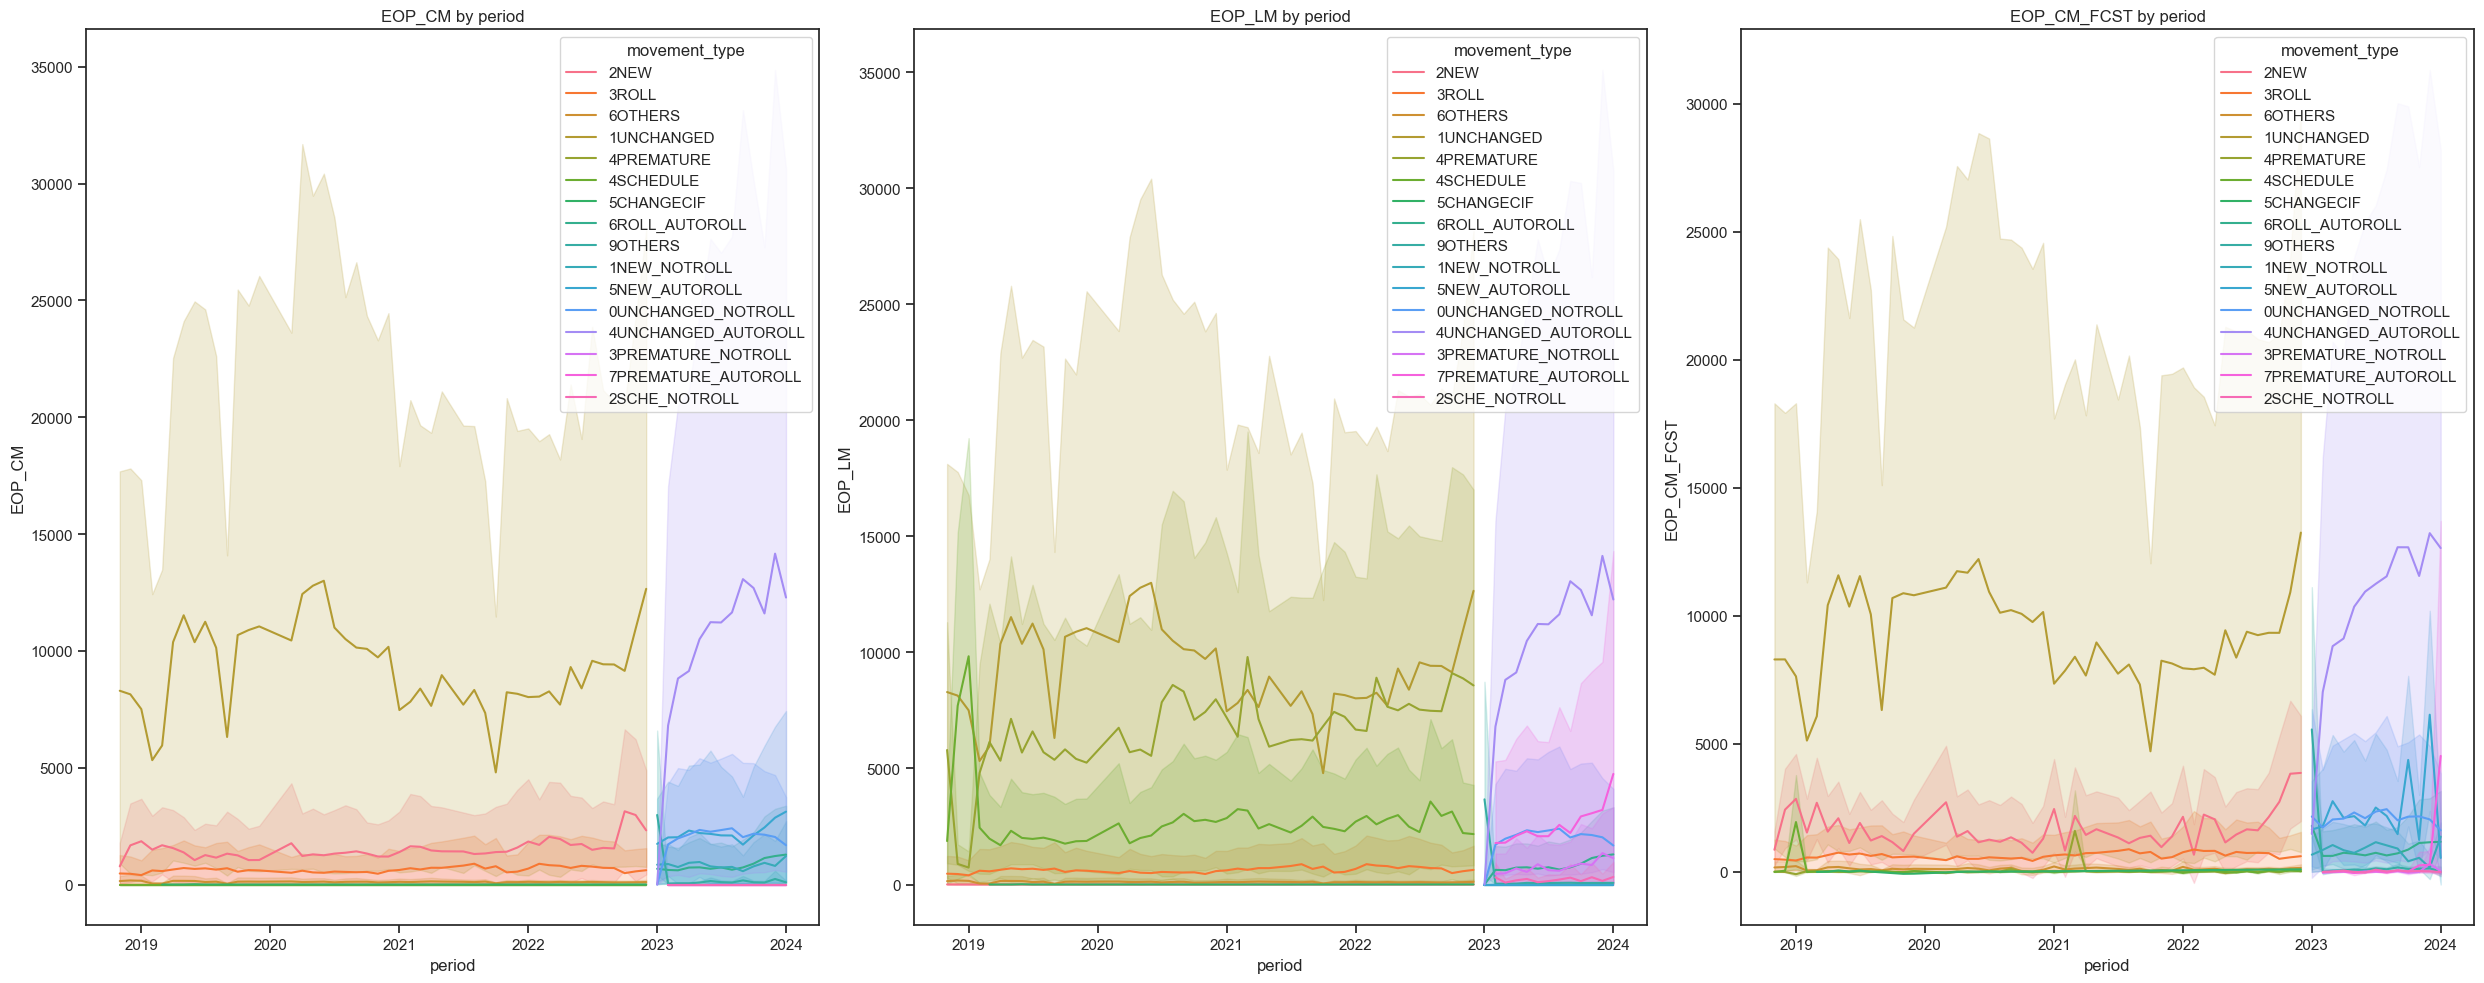

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Trực quan hóa dữ liệu
sns.set(style="ticks")

# Tạo subplot cho các trường dữ liệu cần được click filter
fig, axes = plt.subplots(1, 3, figsize=(25, 10))

# Trực quan hóa EOP_CM theo thời gian period
sns.lineplot(data=df_pres, x='period', y='EOP_CM', hue='movement_type', ax=axes[0])
axes[0].set_title('EOP_CM by period')
axes[0].set_ylabel('EOP_CM')

# Trực quan hóa EOP_LM theo thời gian period
sns.lineplot(data=df_pres, x='period', y='EOP_LM', hue='movement_type', ax=axes[1])
axes[1].set_title('EOP_LM by period')
axes[1].set_ylabel('EOP_LM')

# Trực quan hóa EOP_CM_FCST theo thời gian period
sns.lineplot(data=df_pres, x='period', y='EOP_CM_FCST', hue='movement_type', ax=axes[2])
axes[2].set_title('EOP_CM_FCST by period')
axes[2].set_ylabel('EOP_CM_FCST')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact



# Tạo hàm để trực quan hóa dữ liệu dựa trên các bộ lọc
def visualize_data(movement_type, term_cm, term_lm, currency_2):
    filtered_data = df_pres[(df_pres['movement_type'] == movement_type) & (df_pres['Term_CM'] == term_cm) & (df_pres['Term_LM'] == term_lm) & (df_pres['Currency_2'] == currency_2)]

    sns.set(style="ticks")

    # Tạo subplot cho các trường dữ liệu cần được click filter
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Trực quan hóa EOP_CM theo thời gian period
    sns.lineplot(data=filtered_data, x='period', y='EOP_CM', hue='movement_type', ax=axes[0])
    axes[0].set_title('EOP_CM by period')
    axes[0].set_ylabel('EOP_CM')

    # Trực quan hóa EOP_LM theo thời gian period
    sns.lineplot(data=filtered_data, x='period', y='EOP_LM', hue='movement_type', ax=axes[1])
    axes[1].set_title('EOP_LM by period')
    axes[1].set_ylabel('EOP_LM')

    # Trực quan hóa EOP_CM_FCST theo thời gian period
    sns.lineplot(data=filtered_data, x='period', y='EOP_CM_FCST', hue='movement_type', ax=axes[2])
    axes[2].set_title('EOP_CM_FCST by period')
    axes[2].set_ylabel('EOP_CM_FCST')

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

# Tạo các danh sách các giá trị duy nhất cho mỗi trường dữ liệu
movement_types = df_pres['movement_type'].unique().tolist()
term_cms = df_pres['Term_CM'].unique().tolist()
term_lms = df_pres['Term_LM'].unique().tolist()
currencies = df_pres['Currency_2'].unique().tolist()

# Sử dụng interact để tạo giao diện tương tác với các bộ lọc
interact(
    visualize_data,
    movement_type=movement_types,
    term_cm=term_cms,
    term_lm=term_lms,
    currency_2=currencies
)